# **Named Entity Recognition für Kartenvisualisierung**

In [1]:
import json
from ipywidgets import IntProgress
from datetime import datetime
from tqdm.notebook import tqdm
from collections import Counter
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import pandas as pd
from nltk import ngrams

from IPython.display import clear_output, display

import multiprocessing as mp
cpu_count = mp.cpu_count() - 2

In [2]:
import spacy

nlp = spacy.load("de_core_news_lg")

### **Lister der Staaten und deren alternativer Namen**

von https://de.wiktionary.org/wiki/Verzeichnis:Deutsch/Staatennamen

In [3]:
# Dict mit allen alternativen Namen für Staaten

r = requests.get("https://de.wiktionary.org/wiki/Verzeichnis:Deutsch/Staatennamen")
soup = BeautifulSoup(r.content, "html.parser")

s = {}
for state in soup.find_all("tbody")[1].find_all("tr")[1:]:
    row = state.find_all("td")
    s[row[0].get_text()] = row[0].get_text()
    s[row[2].get_text()] = row[0].get_text()
    try:
        for i in range(len(row[3].get_text().split("/"))):
            s[row[3].get_text().split("/")[i]] = row[0].get_text()
    except IndexError:
        continue

In [4]:
# manuelle Bereinigung:

del s['Vereinigte Staaten (die USA)']
del s['US-amerikanisch, traditionell: amerikanisch']
del s['US-Amerikanerin, traditionell: Amerikaner']
s['Vereinigte Staaten'] = "USA"
s['USA'] = "USA"
s['US-amerikanisch'] = "USA"
s['amerikanisch'] = "USA"
s['US-Amerikanerin'] = "USA"
s['US-Amerikaner'] = "USA"
s['Amerikaner'] = "USA"
s['Amerikanerin'] = "USA"

del s['Vereinigtes Königreich, Großbritannien']
s['madagassisch'] = "Großbritannien"
s['Vereinigtes Königreich'] = "Großbritannien"
s['Brite'] = "Großbritannien"
s['Britin'] = "Großbritannien"
s['britisch'] = "Großbritannien"

'''
s['Schottland'] = "Großbritannien"
s['Schotte'] = "Großbritannien"
s['Schottin'] = "Großbritannien"
s['schottisch'] = "Großbritannien"

s['Wales'] = "Großbritannien"
s['Waliser'] = "Großbritannien"
s['Waliserin'] = "Großbritannien"
s['walisisch'] = "Großbritannien"

s['Nordirland'] = "Großbritannien"
s['Nordire'] = "Großbritannien"
s['Nordirin'] = "Großbritannien"
s['nordirisch'] = "Großbritannien"

s['England'] = "Großbritannien"
s['Engländer'] = "Großbritannien"
s['Engländerin'] = "Großbritannien"
s['englisch'] = "Großbritannien"
'''

del s["---"]
del s["Bahamas (die)"]
s['bahamaisch'] = 'Bahamas'
s['Bahamaer'] = 'Bahamas'
s['Bahamaerin'] = 'Bahamas'
s['Bahamas'] = 'Bahamas'

del s['Belarus, Weißrussland']
del s['belarussisch (weißrussisch)']
del s['Belarussin (Weißrusse']
del s['Weißrussin)']
s['Belarus'] = 'Belarus'
s['Weißrussland'] = 'Belarus'
s['belarussisch'] = 'Belarus'
s['weißrussisch'] = 'Belarus'
s['Belarussin'] = 'Belarus'
s['Belarusse'] = 'Belarus'
s['Weißrusse'] = 'Belarus'
s['Weißrussin'] = 'Belarus'

del s['costa-ricanisch, costaricanisch']
del s['Costa-Ricanerin, Costaricaner']
s['costa-ricanisch'] = 'Costa Rica'
s['costaricanisch'] = 'Costa Rica'
s['Costa-Ricanerin'] = 'Costa Rica'
s['Costaricaner'] = 'Costa Rica'

del s['Côte d’Ivoire (die Elfenbeinküste)']
s['Elfenbeinküste'] = "Elfenbeinküste"
s['Côte d’Ivoire'] = "Elfenbeinküste"
s['ivorisch'] = "Elfenbeinküste"
s['Ivorer'] = "Elfenbeinküste"
s['Ivorerin'] = "Elfenbeinküste"

del s['Dominikanische Republik (die)']
s['Dominikanische Republik'] = 'Dominikanische Republik'
s['dominikanisch'] = 'Dominikanische Republik'
s['Dominikaner'] = 'Dominikanische Republik'
s['Dominikanerin'] = 'Dominikanische Republik'

del s['Ghanaerin (auch Ghanese']
del s['Ghanesin)']
s['Ghanaerin'] = "Ghana"
s['Ghanese'] = "Ghana"
s['Ghanesin'] = "Ghana"

del s['Griechin auch Hellene']
s['Griechin'] = "Griechenland"
s['Hellene'] = "Griechenland"

del s['Heiliger Stuhl (der)']

del s['Irak (der)']
s['Irak'] = "Irak"
s['irakisch'] = "Irak"
s['Iraker'] = "Irak"
s['Irakerin'] = "Irak"

del s['Iran (der)']
s['Iran'] = "Iran"
s['iranisch'] = "Iran"
s['Iraner'] = "Iran"
s['Iranerin'] = "Iran"

del s['Jemen (der)']
s['Jemen'] = "Jemen"
s['jemenitisch'] = "Jemen"
s['Jemenit'] = "Jemen"
s['Jemenitin'] = "Jemen"

del s['Kap Verde (die Kapverdischen Inseln)']
del s['Kap-Verdierin, Kapverdier']
s['Kap Verde'] = "Kap Verde"
s['kapverdisch'] = "Kap Verde"
s['Kapverdier'] = "Kap Verde"
s['Kap-Verdier'] = "Kap Verde"
s['Kap-Verdierin'] = "Kap Verde"
s['Kapverdische Inseln'] = "Kap Verde"
s['Kapverdierin'] = "Kap Verde"

del s['Komoren (die)']
s['Komoren'] = "Komoren"
s['komorisch'] = "Komoren"
s['Komorer'] = "Komoren"
s['Komorerin'] = "Komoren"

del s['Kongo (der)']
s['Kongo'] = "Kongo"
s['kongolesisch'] = "Kongo"
s['Kongolese'] = "Kongo"
s['Kongolesin'] = "Kongo"

del s['Libanon (der)']
s['Libanon'] = "Libanon"
s['libanesisch'] = "Libanon"
s['Libanese'] = "Libanon"
s['Libanesin'] = "Libanon"

del s['Malediven (die)']
s['Malediven'] = "Malediven"
s['maledivisch'] = "Malediven"
s['Malediver'] = "Malediven"
s['Malediverin'] = "Malediven"

del s['Mongolei (die)']
s['Mongolei'] = "Mongolei"
s['mongolisch'] = "Mongolei"
s['Mongole'] = "Mongolei"
s['Mongolin'] = "Mongolei"

del s['Niederlande (die)']
s['Niederlande'] = "Niederlande"
s['niederländisch'] = "Niederlande"
s['Niederländer'] = "Niederlande"
s['Niederländerin'] = "Niederlande"

del s['Niger (der)']
s['Niger'] = "Niger"
s['nigrisch'] = "Niger"
s['Nigrer'] = "Niger"
s['Nigrerin'] = "Niger"

del s['Philippinen (die)']
s['Philippinen'] = "Philippinen"
s['philippinisch'] = "Philippinen"
s['Philippiner'] = "Philippinen"
s['Philippinerin'] = "Philippinen"

del s['Salomonen (die)']
s['Salomonen'] = "Salomonen"
s['salomonisch'] = "Salomonen"
s['Salomoner'] = "Salomonen"
s['Salomonerin'] = "Salomonen"

del s['Schweiz (die)']
s['Schweiz'] = "Schweiz"
s['schweizerisch'] = "Schweiz"
s['Schweizer'] = "Schweiz"
s['Schweizerin'] = "Schweiz"

del s['Senegal (der)']
s['Senegal'] = "Senegal"
s['senegalesisch'] = "Senegal"
s['Senegalese'] = "Senegal"
s['Senegalesin'] = "Senegal"

# del s['Schweiz (die)']
s['Schweiz'] = "Schweiz"
s['schweizerisch'] = "Schweiz"
s['Schweizer'] = "Schweiz"
s['Schweizerin'] = "Schweiz"

del s['Seychellen (die)']
s['Seychellen'] = "Seychellen"
s['seychellisch'] = "Seychellen"
s['Seycheller'] = "Seychellen"
s['Seychellerin'] = "Seychellen"

del s['Slowakei (die)']
s['Slowakei'] = "Slowakei"
s['slowakisch'] = "Slowakei"
s['Slowake'] = "Slowakei"
s['Slowakin'] = "Slowakei"

del s['Südsudan (der)']
s['Südsudan'] = "Südsudan"
s['Südsudanese'] = "Südsudan"
s['Südsudanesin'] = "Südsudan"
s['südsudanesisch'] = "Südsudan"

del s['Sudan (der)']
s['Sudan'] = "Sudan"
s['Sudanese'] = "Sudan"
s['Sudanesin'] = "Sudan"
s['sudanesisch'] = "Sudan"

del s['Tschad (der)']
s['Tschad'] = "Tschad"
s['tschadisch'] = "Tschad"
s['Tschader'] = "Tschad"
s['Tschaderin'] = "Tschad"

del s['Ukraine (die)']
s['Ukraine'] = "Ukraine"
s['ukrainisch'] = "Ukraine"
s['Ukrainer'] = "Ukraine"
s['Ukrainerin'] = "Ukraine"

del s['Türkei (die)']
s['Türkei'] = "Türkei"
s['türkisch'] = "Türkei"
s['Türke'] = "Türkei"
s['Türkin'] = "Türkei"

del s['Vatikanstadt (der Vatikan)']
s['Vatikanstadt'] = "Vatikanstadt"
s['Vatikan'] = "Vatikanstadt"
s['vatikanisch'] = "Vatikanstadt"

del s['madagassisch, madegassisch']
del s['Madagassin, Madegasse']
s['madagassisch'] = "Madagaskar"
s['madegassisch'] = "Madagaskar"
s['Madagassin'] = "Madagaskar"
s['Madegasse'] = "Madagaskar"

del s['Moldau, Moldawien']
s['Moldau'] = "Moldau"
s['Moldawien'] = "Moldau"
s['moldauisch'] = "Moldau"
s['Moldauer'] = "Moldau"
s['Moldauerin'] = "Moldau"

del s['timoresisch,timorisch']
del s['Timoresin, (auch Timorer']
del s['Timorerin)']
s['timoresisch'] = "Timor-Leste"
s['timorisch'] = "Timor-Leste"
s['Timoresin'] = "Timor-Leste"
s['Timorer'] = "Timor-Leste"
s['Timorerin'] = "Timor-Leste"

del s['togoisch, togolesisch']
del s['Togoerin, Togolese']
s['togoisch'] = "Togo"
s['togolesisch'] = "Togo"
s['Togoerin'] = "Togo"
s['Togolese'] = "Togo"

del s['zyprisch, zypriotisch']
del s['Zyprerin,Zypriot']
s['zyprisch'] = "Zypern"
s['zypriotisch'] = "Zypern"
s['Zyprerin'] = "Zypern"
s['Zypriot'] = "Zypern"

s['bosnisch'] = "Bosnien und Herzegowina"

In [5]:
# Lemmas von jedem Eintrag bilden und speichern, da der Vergleich später darüber läuft

alt_names = {}

for key, value in s.items():
    
    doc = nlp(key)
    l = [token.lemma_ for token in doc]
    
    if len(l) == 3:
        new_key = l[0] + " " + l[1] + " " + l[2]
    elif len(l) == 2:
        new_key = l[0] + " " + l[1]
    elif len(l) == 1:
        new_key = l[0]
    alt_names[new_key] = value
    
# Speichern
fout = "states.txt"
fo = open(fout, "w")

for k, v in alt_names.items():
    fo.write(str(k) + ':'+ str(v) + "\n")

fo.close()

### **Einlesen der Untertitel**

In [6]:
# 1. Folge 05.06.2014 -> Erster Monat Juli-2014
# Letzte Folge 31.05.2021 -> Letzter Monat Mai-2021
# -> Untersuchungszeitrum 83 Monate

data = {}
error_list = []
count = 0
# Episoden laden
for year in range(2014, 2022):
    start = 1
    end = 13
    if year == 2014:
        start = 7
    if year == 2021:
        end = 6

        
    data[year] = {}
    for month in range(start,end):
     
        if month in [1, 3, 5, 7, 8, 10, 11]:
            tage = 31
        elif month in [4, 6, 9, 11]:
            tage = 30
        else:
            if year % 4 == 0:
                tage = 29
            else:
                tage = 28
        
        if month < 10:
            month_path = "0" + str(month)
        else:
            month_path = str(month)
        m_list = []
        for day in range(1, tage):
            if day < 10:
                day = "0" + str(day)
            path = "subs/Tagesschau_" + str(day) + "-" + month_path + "-" + str(year) + ".json"
            try:            
                with open(path) as f:
                    episode = json.load(f)
                m_list.append(episode["transcript"])
                count +=1
            except FileNotFoundError:
                error_list.append((year, month))
                continue
        data[year][month] = m_list

print("Anzahl vorhandener Folgen im Untersuchungszeitraum: " + str(count))
print("Anzahl fehlender Folgen im Untersuchungszeitraum: " + str(len(error_list)))
ctn = Counter(error_list)
print(ctn.most_common())
with open("error_list.txt", 'w') as file_handler:
    file_handler.write("\n".join(str(item) for item in error_list))

# Absätze und Anfang entfernen
x = 0
for year, value in data.items():
    for month, days in value.items():
        for d, day in enumerate(days):
            data[year][month][d] = day.replace("\n", " ").replace("  ", " ")
            try:
                # "Deutsche" in der Ansage entfernen, da es sonst als Named Entity zählen würde
                data[year][month][d] = data[year][month][d].split("Deutsche Fernsehen")[1]
            except IndexError:
                x += 1
                continue
print("Folgen ohne 'Deutsche Fernsehen':",  x) # In den meisten Fällen kurze Tagesthemen

Anzahl vorhandener Folgen im Untersuchungszeitraum: 2295
Anzahl fehlender Folgen im Untersuchungszeitraum: 137
[((2015, 5), 8), ((2015, 3), 6), ((2016, 1), 5), ((2014, 9), 4), ((2015, 2), 4), ((2015, 4), 4), ((2015, 6), 4), ((2015, 7), 4), ((2016, 2), 4), ((2017, 2), 4), ((2014, 12), 3), ((2015, 9), 3), ((2016, 8), 3), ((2016, 10), 3), ((2017, 3), 3), ((2020, 2), 3), ((2021, 4), 3), ((2014, 7), 2), ((2014, 8), 2), ((2014, 10), 2), ((2014, 11), 2), ((2015, 1), 2), ((2016, 3), 2), ((2016, 4), 2), ((2016, 6), 2), ((2016, 7), 2), ((2016, 12), 2), ((2017, 6), 2), ((2017, 7), 2), ((2018, 6), 2), ((2018, 7), 2), ((2018, 8), 2), ((2019, 3), 2), ((2019, 8), 2), ((2019, 10), 2), ((2020, 3), 2), ((2020, 4), 2), ((2020, 5), 2), ((2020, 6), 2), ((2020, 10), 2), ((2021, 2), 2), ((2021, 3), 2), ((2015, 8), 1), ((2015, 10), 1), ((2015, 11), 1), ((2015, 12), 1), ((2016, 5), 1), ((2016, 9), 1), ((2016, 11), 1), ((2017, 1), 1), ((2017, 4), 1), ((2017, 8), 1), ((2017, 10), 1), ((2018, 1), 1), ((2018, 3), 

### **Named Entity Recognition mit SpaCy**

In [7]:
# LOC Named Entities identifizieren und auf Monatsebene speichern

def get_ents(episode):
    doc = nlp(episode)
    m_list = []
    for ent in doc.ents:
        if ent.text.startswith("US-"):  # Sonderfall abfangen, vorher war USA stark unterrepräsentiert
                                        # Gibt es ein anderes Land, bei dem man so ein Präfix verwendet?
            m_list.append("USA")
        elif ent.label_ == "LOC":
            m_list.append(ent.text)
    return m_list

spacy_dict = {}

for year, value in tqdm(data.items()):
    for month, days in value.items():
        key = str(year) + "-" + str(month)
        if __name__ == '__main__':
            with mp.Pool(cpu_count) as pool:
                m_list = pool.map(get_ents, days)
            
        spacy_dict[key] = [item for sublist in m_list for item in sublist]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
# Gefundene Entities mit Liste der alternativen Namen abgleichen und ggf. speichern

def get_lemmas(mon):
    ret_list = []
    for ne in mon:
        
        doc = nlp(ne)
        l = [token.lemma_ for token in doc]
        
        # 1-grams abgleichen
        found = False
        for lemma in l:
            if lemma in alt_names.keys():
                ret_list.append(alt_names[lemma])
                found = True
                break
                
        # 2-grams abgleichen
        if not found:
            grams = ngrams(l, 2)
            for gram in grams:
                lemma = gram[0] + " " + gram[1]
                if lemma in alt_names.keys():
                    ret_list.append(alt_names[lemma])
                    found = True
                    break
        # 3-grams abgleichen
        if not found:
            grams = ngrams(l, 3)
            for gram in grams:
                lemma = gram[0] + " " + gram[1] + " " + gram[2]
                if lemma in alt_names.keys():
                    ret_list.append(alt_names[lemma])
                    found = True
                    break       
        
    return ret_list

ner_dict = {}

for key, value in tqdm(spacy_dict.items()):
    #if __name__ == '__main__':
       # with mp.Pool(cpu_count) as pool:
       #     result = pool.map(get_lemmas, value)
    #ner_list = [item for sublist in result for item in sublist]
    ctn = Counter(get_lemmas(value))
    # ctn = Counter(ner_list)
    ner_dict[key] = ctn
    
    
# Dictionary für pandas vorbereiten

states = alt_names.values()
states = set(states)
df_dict = {}

for key, value in ner_dict.items():
    df_dict[key] = {}
    for state in states:
        df_dict[key][state] = 0
    for s_key, s_value in value.items():
        df_dict[key][s_key] = s_value

  0%|          | 0/83 [00:00<?, ?it/s]

In [9]:
# Anzahl für Monate nach Anzahl der Folgen pro Monat normalisieren
# -> Zahl = wie oft wurde das Land pro Folge in diesem Monat erwähnt
len_dict = {}
for year in data:
    for month in data[year]:
        len_dict[str(year) + "-" + str(month)] = len(data[year][month])

for key, value in df_dict.items():
    for entry in value:
        df_dict[key][entry] = df_dict[key][entry] / len_dict[key]

In [10]:
with open('ner_dict.json', 'w') as fp:
    json.dump(df_dict, fp)

In [11]:
df = pd.DataFrame.from_dict(df_dict)
df.to_pickle("ner_df.pkl")
df.head(5)

,2014-7,2014-8,2014-9,2014-10,2014-11,2014-12,2015-1,2015-2,2015-3,2015-4,...,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4,2021-5
Elfenbeinküste,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
Portugal,0.0,0.142857,0.00,0.071429,0.035714,0.0,0.035714,0.0,0.041667,0.0,...,0.000000,0.000000,0.035714,0.000000,0.037037,0.233333,0.20,0.107143,0.115385,0.066667
Äquatorialguinea,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.035714,0.000000,0.000000
Albanien,0.0,0.035714,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.033333,0.034483,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
Äthiopien,0.0,0.000000,0.04,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.266667,0.074074,0.000000,0.12,0.000000,0.038462,0.033333


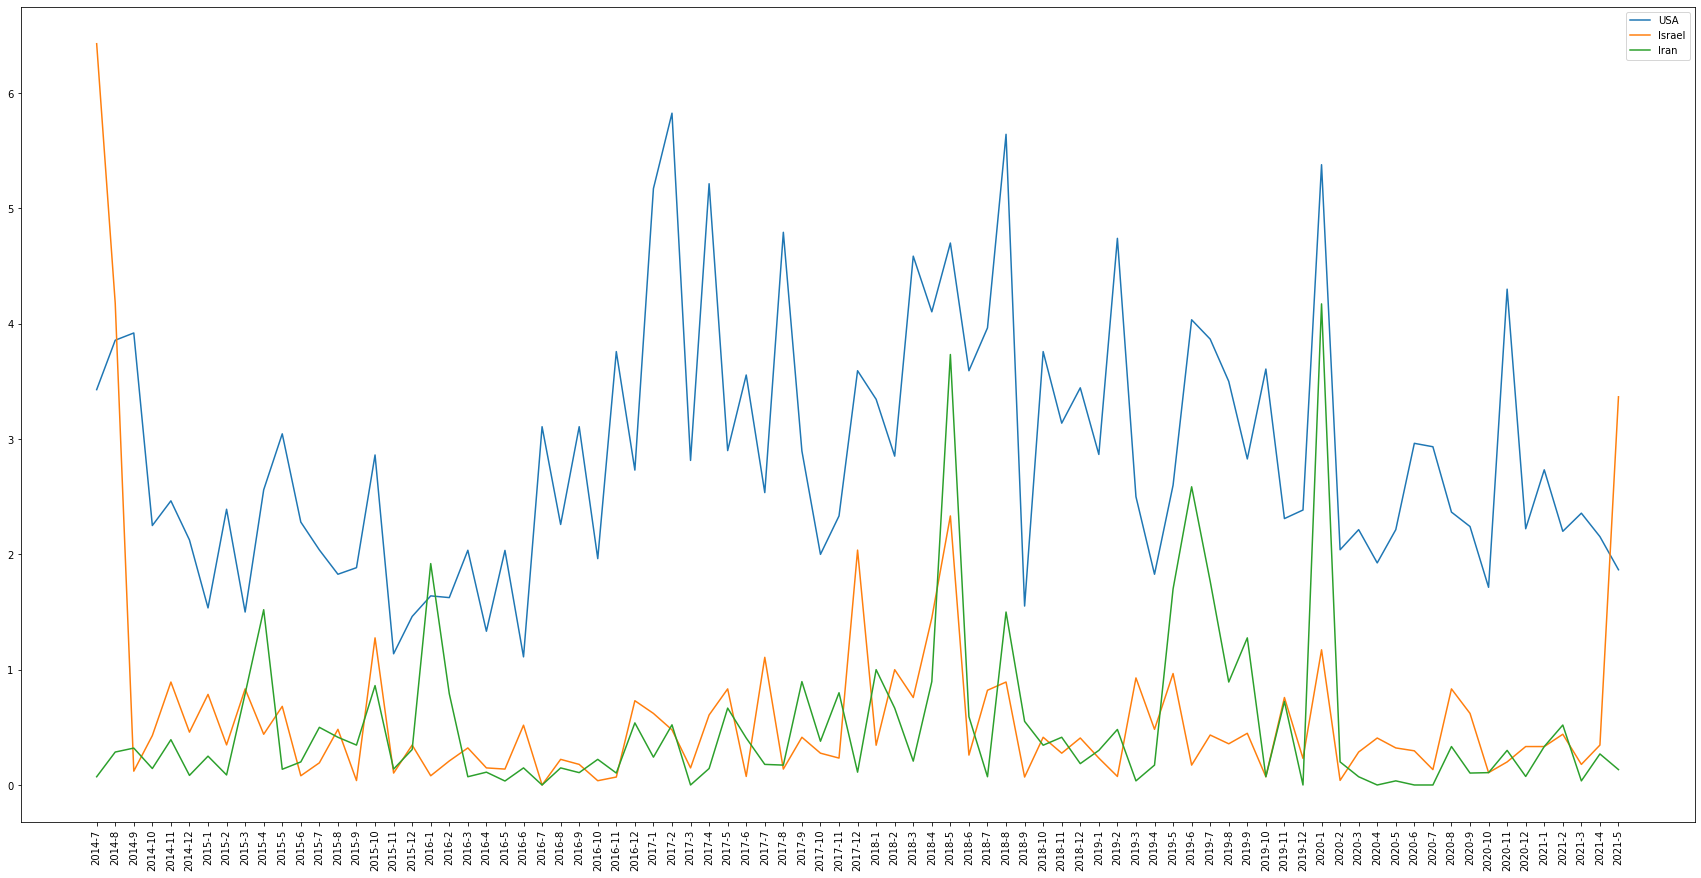

In [12]:
labels = ['USA',
             'Israel',
             'Iran']
pl = [df.loc[x].tolist() for x in labels]
months = df.columns.tolist()

plt.rcParams["figure.figsize"] = (30,15)

for i, state in enumerate(pl):
    plt.plot(months, state, label=labels[i])
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [13]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(pl[1][5:-2], pl[2][5:-2])
print(corr, p_value)

0.42713234581173054 0.00011906780321886854


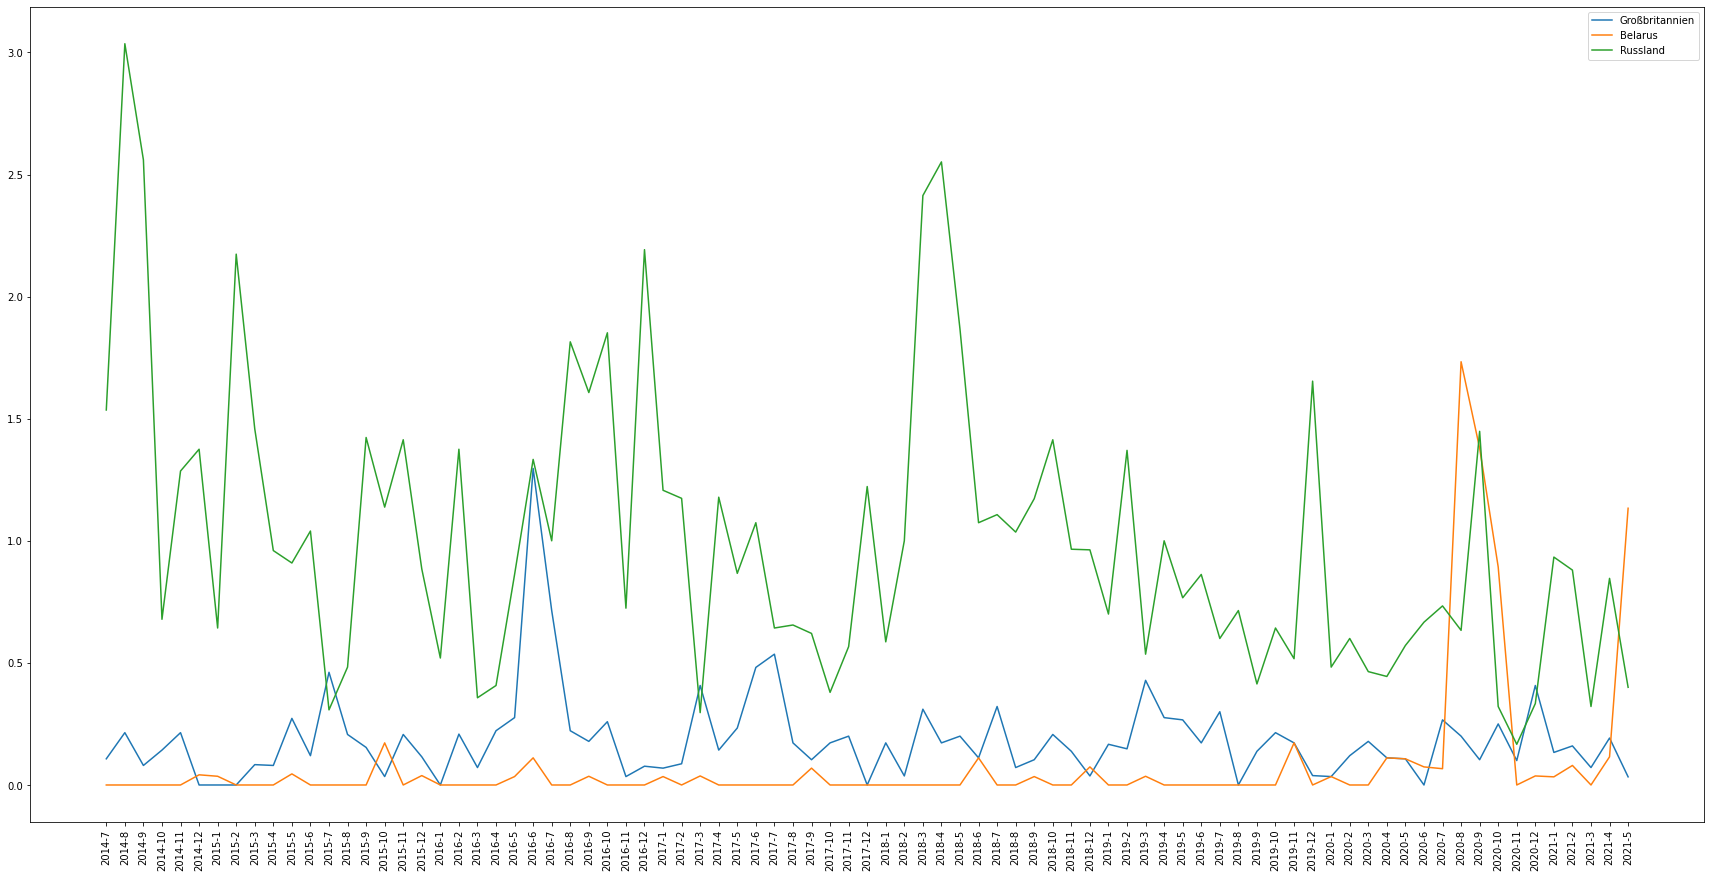

In [14]:
labels = ['Großbritannien',
          "Belarus",
         "Russland"]
pl = [df.loc[x].tolist() for x in labels]
months = df.columns.tolist()

plt.rcParams["figure.figsize"] = (30,15)

for i, state in enumerate(pl):
    plt.plot(months, state, label=labels[i])
plt.legend()
plt.xticks(rotation=90)
plt.savefig("uk_neu")
plt.show()

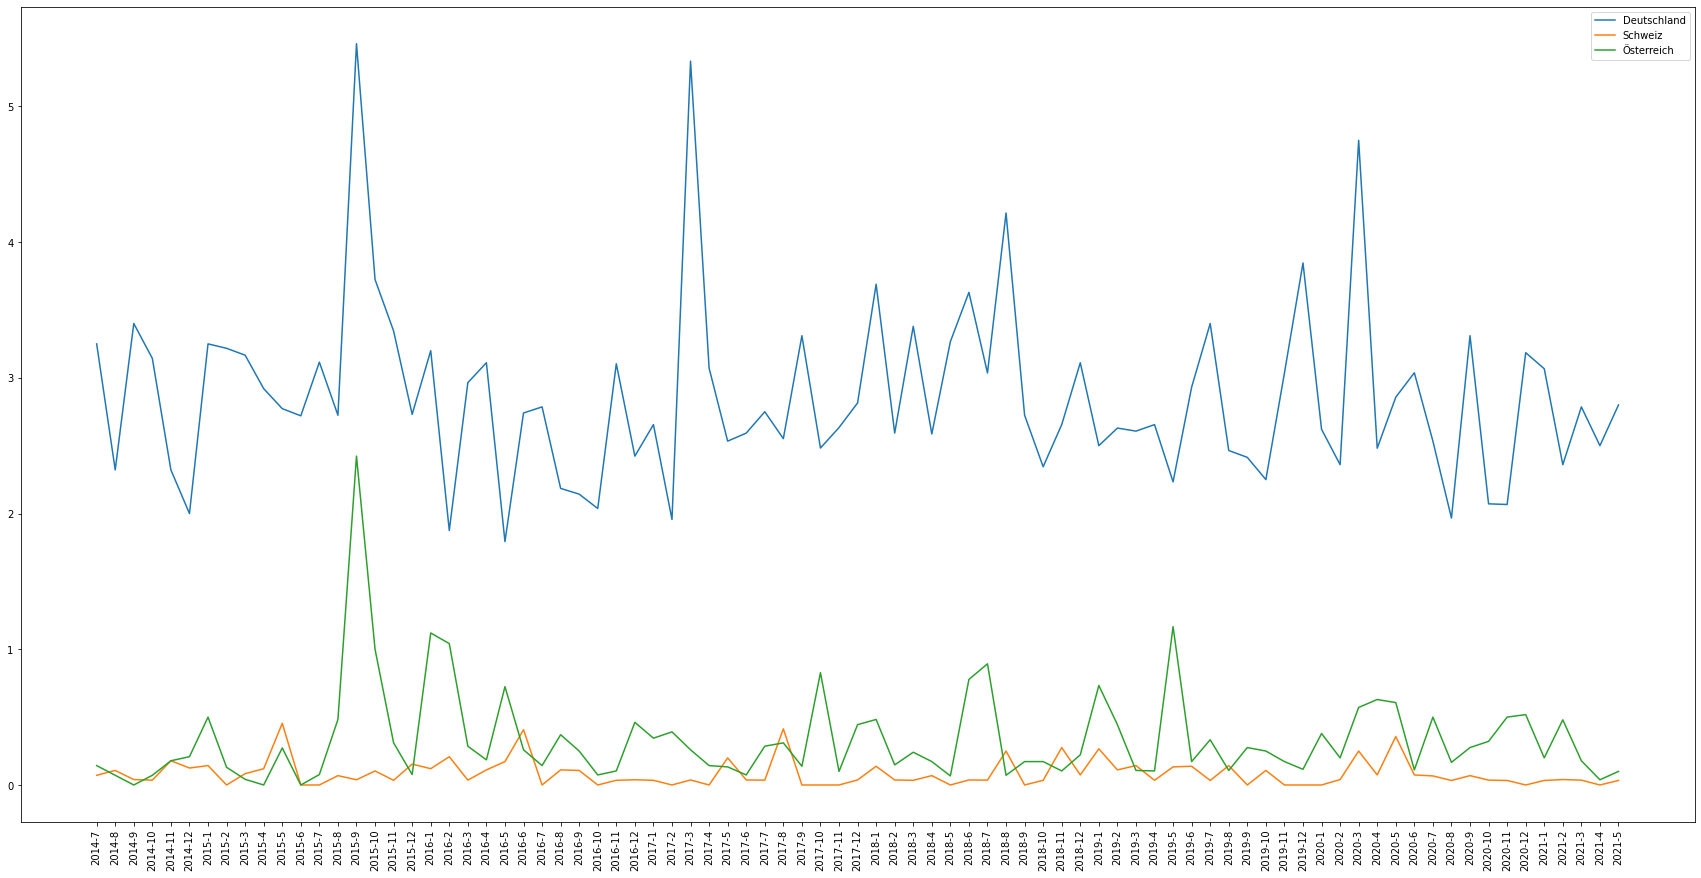

In [15]:
labels = ['Deutschland',
             'Schweiz',
             'Österreich']
pl = [df.loc[x].tolist() for x in labels]
months = df.columns.tolist()

plt.rcParams["figure.figsize"] = (30,15)

for i, state in enumerate(pl):
    plt.plot(months, state, label=labels[i])
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [4]:
ner_df = pd.read_pickle("ner_df.pkl")

In [20]:
ner_df.head(1)

,2014-7,2014-8,2014-9,2014-10,2014-11,2014-12,2015-1,2015-2,2015-3,2015-4,...,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4,2021-5
Elfenbeinküste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
with open('Tagesschau/data/world.geo.json') as f:
    geojson = json.load(f)

In [ ]:
# Englische Staatennamen aus GeoJson mit Staaten verknüpfen, da diese später als ID dienen

geo_id = {}
for state in sorted(ner_df.index.tolist()):
    geo_id[state] = 0

# Automatisch für alle Länder, deren englischer Name == deutscher Name
for ent in geojson["features"]:
    if ent["properties"]["NAME"] in geo_id:
        geo_id[ent["properties"]["NAME"]] = ent["properties"]["NAME"]
        
# manuell für Rest        
for state, value in geo_id.items():
    if value == 0:
        print(state)
        i_d = input("ID?")
        geo_id[state] = i_d

In [21]:
with open('geo_id_2.json', 'w') as fp:
    json.dump(geo_id, fp)

In [20]:
# Staaten, die nicht in der GeoJson auftauchen, weil sie zu klein sind
# -> raus aus den Daten

for state in geo_id.keys():
    if geo_id[state] == "0":
        print(state)
        geo_id[state] = 0

### **Kookkurrenzen finden**

In [38]:
# Bereinigte Daten laden

cleaned_data = {}

for year in range(2014, 2022):
    start = 1
    end = 13
    if year == 2014:
        start = 7
    if year == 2021:
        end = 6

    cleaned_data[year] = {}
    for month in range(start,end):
            
        if month < 10:
            month_path = "0" + str(month)
        else:
            month_path = str(month)
        m_list = []
        path = "cleaned_subs/" + month_path + "-" + str(year) + ".json"
        try:            
            with open(path) as f:
                lemmas = json.load(f)
        except FileNotFoundError:
            print(year, month)
            continue
                
        cleaned_data[year][month] = lemmas

In [ ]:
# Cooccurrences finden und speichern

coocc_dict = {}
for year in cleaned_data:
    for month in cleaned_data[year]:
        key = str(year) + "-" + str(month)
        coocc_dict[key] = {}
    
for state in tqdm(set(alt_names.values())):
    alts = []
    for alt_name, value in alt_names.items():
        if value == state:
            alts.append(alt_name.lower())
    
    for year in cleaned_data:
        for month in cleaned_data[year]:
            key = str(year) + "-" + str(month)
            c_list = []
            
            # 1-grams finden
            for i, token in enumerate(cleaned_data[year][month]):
                if token in alts:
                    c_list.append(cleaned_data[year][month][i-3:i+7])
                    
            # 2-grams finden
            grams = ngrams(cleaned_data[year][month], 2)
            for i, gram in enumerate(grams):
                lemma = gram[0] + " " + gram[1]
                if lemma.lower() in alts:
                    c_list.append(cleaned_data[year][month][i-4:i+6]) # i-1, weil bei 2 grams der erste Token des Dokuments nicht exisitiert

            # 3-grams finden
            grams = ngrams(cleaned_data[year][month], 3)
            for i, gram in enumerate(grams):
                lemma = gram[0] + " " + gram[1] + " " + gram[2]
                if lemma.lower() in alts:
                    c_list.append(cleaned_data[year][month][i-5:i+5]) # i-2, weil bei 2 grams der erste Token des Dokuments nicht exisitiert

            cc_list = [item for sublist in c_list for item in sublist]
            ctn = Counter(cc_list)
            for entry in alts:
                del ctn[entry]
            coocc_dict[key][state] = ctn.most_common(10)

In [18]:
with open('co-occurrences.json', 'w') as fp:
    json.dump(coocc_dict, fp)

In [23]:
with open('co-occurrences.json') as f:
    coocc_dict = json.load(f)

In [24]:
df_cc = pd.DataFrame.from_dict(coocc_dict)
df_cc.head(5)

,2014-7,2014-8,2014-9,2014-10,2014-11,2014-12,2015-1,2015-2,2015-3,2015-4,...,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4,2021-5
Jemen,[],[],[],"[[staatenbündnis, 1], [eingreifen, 1], [protes...",[],[],"[[al, 4], [kaida, 4], [sanaa, 3], [hauptstadt,...","[[gericht, 1], [angespannter, 1], [lage, 1], [...","[[schiitisch, 8], [präsident, 7], [saudi-arabi...","[[schiitisch, 5], [saudi-arabien, 5], [huthi-r...",...,[],[],"[[gefangene, 2], [freigelassen, 2], [beamt, 1]...","[[job, 1], [obdachlosigkeit, 1], [hungersnot, ...",[],"[[mensch, 2], [kind, 2], [million, 2], [situat...",[],"[[mensch, 4], [schlimm, 3], [süden, 3], [krieg...",[],[]
Dominikanische Republik,[],[],[],[],[],[],[],[],[],[],...,"[[exil, 1], [aufenthaltsort, 1], [unbekannt, 1...",[],[],[],[],[],[],[],[],[]
Katar,"[[hamas, 8], [seite, 4], [ägypten, 4], [türkei...","[[hamas-führung, 2], [gaza, 1], [angriffen, 1]...","[[is, 4], [terroristisch, 4], [emir, 3], [geld...",[],"[[vergabe, 2], [russland, 2], [wm-turniere, 1]...","[[wm-vergabe, 3], [russland, 2], [korruptionsv...","[[team, 4], [wm, 3], [polen, 3], [deutschland,...","[[november, 3], [dezember, 3], [fifa, 3], [som...","[[fußball-weltverband, 2], [wm, 2], [finale, 2...",[],...,"[[haftar, 2], [al-sarraj, 1], [türkei, 1], [ru...",[],[],[],"[[qualifizieren, 2], [gruppe, 2], [ort, 2], [w...","[[iran, 3], [saudisch, 3], [blockade, 2], [emi...","[[fc, 1], [barcelona, 1], [bayern, 1], [klub-w...","[[erfolgreich, 1], [qualifikation, 1], [fußbal...",[],"[[ablehnend, 1], [anruf, 1], [ägypten, 1], [un..."
Mikronesien,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
São Tomé und Príncipe,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [26]:
# Dictionary mit Cooccurences für ganzes Korpus:

cc_gesamt_dict = {}
for state in list(df_cc.index.values):
    llist = [item for sublist in df_cc.loc[state].tolist() for item in sublist]
    mlist = []
    for word in llist:
        for i in range(word[1]):
            mlist.append(word[0])
    ctn = Counter(mlist)
    cc_gesamt_dict[state] = ctn.most_common()


In [27]:
for state in cc_gesamt_dict:
    temp = [c[0] for c in cc_gesamt_dict[state][:15]]
    cc_gesamt_dict[state] = temp

In [22]:
# Test-Datei erstellen

ner_df.head(1)

,2014-7,2014-8,2014-9,2014-10,2014-11,2014-12,2015-1,2015-2,2015-3,2015-4,...,2020-8,2020-9,2020-10,2020-11,2020-12,2021-1,2021-2,2021-3,2021-4,2021-5
Elfenbeinküste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Für Javascript vorbereiten

outstr = "export var nerData = [\n"
string = "  {{\n    state_id: {state_id},\n    state_name: {state_name},\n    count: {count},\n    coocc: {coocc}\n  }},\n"
for state in geo_id:
    if geo_id[state] != 0:
        stateout = '"' + state + '"'
        stateout_id = '"' + geo_id[state] + '"'
        outstr += string.format(state_id = stateout_id, state_name = stateout, count = round(sum(ner_df.loc[state].tolist()), 2), coocc = cc_gesamt_dict[state])
outstr += "]"

In [33]:
with open("Tagesschau/data/ner.js", 'w') as f:
    f.write(outstr)

In [37]:
print(outstr[:400])

export var nerData = [
  {
    state_id: "Afghanistan",
    state_name: "Afghanistan",
    count: 20.63,
    coocc: ['taliban', 'soldat', 'land', 'mensch', 'flüchtling', 'anschlag', 'bundeswehr', 'kabul', 'regierung', 'deutschland', 'deutsch', 'syrien', 'usa', 'einsatz', 'armee']
  },
  {
    state_id: "Albania",
    state_name: "Albanien",
    count: 1.77,
    coocc: ['kosovo', 'montenegro', 'eu'
